In [1]:
import sqlite3
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as optlgb
from sklearn.model_selection import KFold
import numpy as np
import datetime as dt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import race_data
import models.ml_racer_prize_lgb as ml_lgb
import models.preprocessing_racer_prize_lgb as pp_lgb

In [2]:
dbname = "backend.db"

In [3]:
df_race = pd.DataFrame(race_data.get_results(dbname, "race", "where status = 'FINISHED'"), columns= race_data.RASE_COLS)

In [4]:
df_timetable_racer = pd.DataFrame(race_data.get_results(dbname,"timetable_racer", None),columns= race_data.TIMETABLE_RACER_COLS)

In [5]:
df_racer_result = pd.DataFrame(race_data.get_results(dbname, "racer_result", "where time is not null"),columns= race_data.RACER_RESULT_COLS)

In [15]:
# 使わないセルを削除
df_race.drop(["title_name", "create_at", "status"], axis=1, inplace=True)

In [16]:
# 使わないセルを削除 resultはひとまず削除
df_timetable_racer.drop(["name", 
                         "result_1", 
                         "result_2", 
                         "result_3", 
                         "result_4", 
                         "result_5", 
                         "result_6",
                         "create_at"], axis=1, inplace=True)

In [17]:
df_racer_result.drop(["result_id", "create_at"], axis=1, inplace=True)

In [17]:
df_race.place = df_race.place.astype(np.int32)
df_race.race_number = df_race.race_number.astype(np.int32)
df_race.deadline = pd.to_datetime(df_race.deadline)

In [19]:
df_timetable_racer.racer_id = df_timetable_racer.racer_id.astype(np.int32)
df_timetable_racer.moter_id = df_timetable_racer.moter_id.astype(np.int32)
df_timetable_racer.boat_id = df_timetable_racer.boat_id.astype(np.int32)

In [20]:
df_timetable_racer["rank"].replace(race_data.RANK_NUM, inplace=True)

In [8]:
all_data = pd.merge(df_race, df_timetable_racer, on=['race_id'])
all_data = pd.merge(all_data, df_racer_result, on=['time_table_racer_id'])

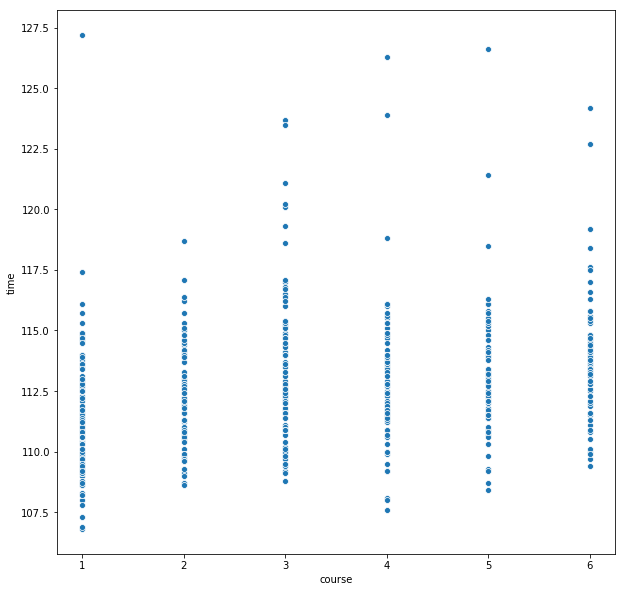

In [23]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='course', y='time', data=all_data[all_data.distance == 1800].sample(500))

# ここから前処理

### ここからレース毎の集計(train とtestを分ける前に行って問題ない集計処理)

In [26]:
all_data["month"] = all_data.deadline.dt.month

In [27]:
all_data["is_short_race"] = all_data.distance != 1800

In [28]:
course_1_racer = all_data[all_data.course == 1]
grouped_df = course_1_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'course_1_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_racer = all_data[all_data.course == 2]
grouped_df = course_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'course_2_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_racer = all_data[all_data.course == 3]
grouped_df = course_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'course_3_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_racer = all_data[all_data.course == 4]
grouped_df = course_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'course_4_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_racer = all_data[all_data.course == 5]
grouped_df = course_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'course_5_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_racer = all_data[all_data.course == 6]
grouped_df = course_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'course_6_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

In [29]:
course_1_racer = all_data[all_data.course == 1]
grouped_df = course_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'course_1_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_1_racer = all_data[all_data.course == 2]
grouped_df = course_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'course_2_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_1_racer = all_data[all_data.course == 3]
grouped_df = course_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'course_3_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_1_racer = all_data[all_data.course == 4]
grouped_df = course_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'course_4_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_1_racer = all_data[all_data.course == 5]
grouped_df = course_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'course_5_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

course_1_racer = all_data[all_data.course == 6]
grouped_df = course_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'course_6_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

In [30]:
all_train_data = all_data[(all_data.deadline < dt.datetime(2020,7,1))]
test_data = all_data[(dt.datetime(2020,7,1) <= all_data.deadline) & (all_data.deadline <= dt.datetime(2020,7,30))]

### 平均タイムとかの集計は、学習データのみでする必要がある

In [31]:
train_data , valid_data = train_test_split(all_train_data, random_state=0, test_size=0.2)

In [32]:
# moter_id
grouped_df = train_data.groupby(["moter_id"]).time.mean()
grouped_df.name = 'mean_time_by_moter_id'
train_data = pd.merge(train_data, grouped_df, on=["moter_id"])
valid_data = pd.merge(valid_data, grouped_df, on=["moter_id"])
test_data= pd.merge(test_data, grouped_df, on=["moter_id"])

In [33]:
# 場所、コース毎の順位
grouped_df = train_data.groupby(["course","place"]).prize.mean()
grouped_df.name = 'mean_prize_by_course_place'
train_data = pd.merge(train_data, grouped_df, on=["course","place"])
valid_data = pd.merge(valid_data, grouped_df, on=["course","place"])
test_data= pd.merge(test_data, grouped_df, on=["course","place"])

In [34]:
# 場所、コース毎の順位
grouped_df = train_data.groupby(["course","place"]).prize.median()
grouped_df.name = 'median_prize_by_course_place'
train_data = pd.merge(train_data, grouped_df, on=["course","place"])
valid_data = pd.merge(valid_data, grouped_df, on=["course","place"])
test_data= pd.merge(test_data, grouped_df, on=["course","place"])

In [35]:
# moter_id
grouped_df = train_data.groupby(["moter_id"]).prize.mean()
grouped_df.name = 'mean_prize_by_moter_id'
train_data = pd.merge(train_data, grouped_df, on=["moter_id"])
valid_data = pd.merge(valid_data, grouped_df, on=["moter_id"])
test_data= pd.merge(test_data, grouped_df, on=["moter_id"])

In [36]:
# moter_id
grouped_df = train_data.groupby(["moter_id"]).prize.median()
grouped_df.name = 'median_prize_by_moter_id'
train_data = pd.merge(train_data, grouped_df, on=["moter_id"])
valid_data = pd.merge(valid_data, grouped_df, on=["moter_id"])
test_data= pd.merge(test_data, grouped_df, on=["moter_id"])

In [37]:
# 場所、コース毎のタイム(1800mのみ)
grouped_df = train_data[train_data.distance == 1800].groupby(["course","place"]).time.mean()
grouped_df.name = 'mean_time_by_course_place'
train_data = pd.merge(train_data, grouped_df, on=["course","place"])
valid_data = pd.merge(valid_data, grouped_df, on=["course","place"])
test_data= pd.merge(test_data, grouped_df, on=["course","place"])

In [38]:
# 場所、コース毎のタイム(1800mのみ)
grouped_df = train_data[train_data.distance == 1800].groupby(["course","place"]).time.median()
grouped_df.name = 'median_time_by_course_place'
train_data = pd.merge(train_data, grouped_df, on=["course","place"])
valid_data = pd.merge(valid_data, grouped_df, on=["course","place"])
test_data= pd.merge(test_data, grouped_df, on=["course","place"])

In [39]:
# 場所、コース毎のタイム(1800mのみ)
grouped_df = train_data[train_data.distance == 1800].groupby(["place"]).time.median()
grouped_df.name = 'median_time_by_place'
train_data = pd.merge(train_data, grouped_df, on=["place"])
valid_data = pd.merge(valid_data, grouped_df, on=["place"])
test_data= pd.merge(test_data, grouped_df, on=["place"])

grouped_df = train_data[train_data.distance == 1800].groupby(["place"]).time.mean()
grouped_df.name = 'mean_time_by_place'
train_data = pd.merge(train_data, grouped_df, on=["place"])
valid_data = pd.merge(valid_data, grouped_df, on=["place"])
test_data= pd.merge(test_data, grouped_df, on=["place"])

## ここから機械学習

In [40]:
# 2020/07のレース結果を予測する
# 利用するデータは2020/06までのもの

In [9]:
cols = [
    "place",
    "race_number",
#     "distance",
    "course",
    "age",
    "weight",
    "rank",
    "win_rate",
    "exacta_rate",
    "win_rate_place",
    "exacta_race_place",
    "moter_id",
    "exacta_race_mortor",
    "boat_id",
    "exacta_race_boat",
    "exhibition_time",
    "tilt",
    "month",
    "mean_time_by_place",
    "median_time_by_place",
    'mean_time_by_course_place',
    "median_time_by_course_place",
    "racer_id",
    'course_1_racer_id',
    'course_2_racer_id',
    'course_3_racer_id',
    'course_4_racer_id',
    'course_5_racer_id',
    'course_6_racer_id',
    'mean_prize_by_course_place',
    'median_prize_by_course_place',
#     'mean_prize_by_moter_id',
#     'median_prize_by_moter_id',
#     'course_1_win_rate',
#     'course_2_win_rate',
#     'course_3_win_rate',
#     'course_4_win_rate',
#     'course_5_win_rate',
#     'course_6_win_rate',
#     'mean_time_by_moter_id',
#     "mean_time_by_course"
#     "is_short_race"
]
len(cols)

30

In [42]:
train_dataset = lgb.Dataset(train_data[cols], train_data["prize"])
valid_dataset = lgb.Dataset(valid_data[cols], valid_data["prize"])

In [12]:
params = {'bagging_fraction': 0.9898106657338858,
 'bagging_freq': 1,
 'feature_fraction': 0.8,
 'feature_pre_filter': False,
 'lambda_l1': 8.559554598335243,
 'lambda_l2': 1.9907443721757583,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_data_in_leaf': 20,
 'num_leaves': 26,
 'objective': 'regression',
 'random_seed': 0}

In [44]:
# tuner = optlgb.LightGBMTunerCV(tuner.best_params, train_dataset,
#                             num_boost_round=10000,
#                             verbose_eval=1000, early_stopping_rounds=100, folds=KFold(n_splits=5))

# ハイパーパラメータ探索の実行
# tuner.run()

In [45]:
# tuner.best_params

In [21]:
lbgm = lgb.train(params, train_dataset, valid_sets=[valid_dataset],
                num_boost_round=10000, early_stopping_rounds=10, verbose_eval=1000)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[133]	valid_0's rmse: 1.15781


In [22]:
lbgm.best_score['valid_0']['rmse']

1.1578108966122675

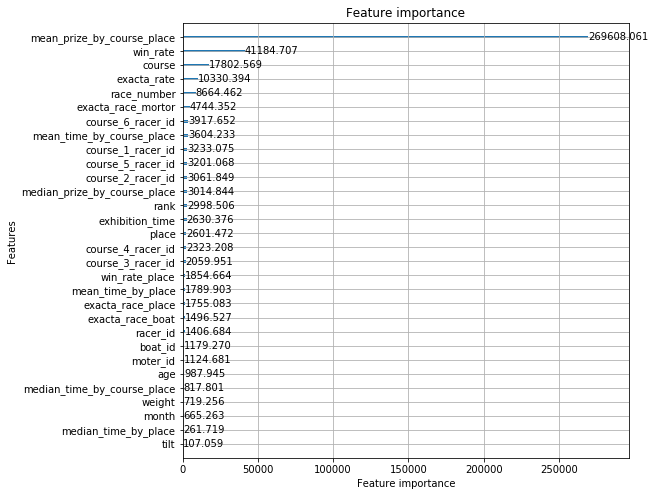

In [23]:
lgb.plot_importance(lbgm, importance_type='gain', figsize=(8, 8))

# ここから予測結果のスコア計算

In [25]:
pred = lbgm.predict(test_data[cols])
df_pred = test_data[["race_id", "distance", "course", "prize", "time"]]
df_pred["pred_prize"] = pred

# 一位予想
pred_first_prize = df_pred.groupby(["race_id"]).pred_prize.min()
pred_first_prize = pred_first_prize.rename("pred_1st_prize")
df_pred = pd.merge(df_pred, pred_first_prize, on="race_id")
df_pred["is_1st_pred"] = (df_pred.pred_prize == df_pred.pred_1st_prize)

# 二位予想
pred_second_prize = df_pred.loc[df_pred.is_1st_pred == False].groupby(["race_id"]).pred_prize.min()
pred_second_prize = pred_second_prize.rename("pred_2nd_prize")
df_pred = pd.merge(df_pred, pred_second_prize, on="race_id")
df_pred["is_2nd_pred"] = (df_pred.pred_prize == df_pred.pred_2nd_prize)

# 3位予想
pred_second_prize = df_pred.loc[(df_pred.is_1st_pred == False) & (df_pred.is_2nd_pred == False)].groupby(["race_id"]).pred_prize.min()
pred_second_prize = pred_second_prize.rename("pred_3rd_prize")
df_pred = pd.merge(df_pred, pred_second_prize, on="race_id")
df_pred["is_3rd_pred"] = (df_pred.pred_prize == df_pred.pred_3rd_prize)

df_pred["is_1st"] = (df_pred.prize == 1.0)
df_pred["is_2nd"] = (df_pred.prize == 2.0)
df_pred["is_3rd"] = (df_pred.prize == 3.0)


/Users/kobayashiyouta/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
confusion_matrix(df_pred.is_1st, df_pred.is_1st_pred)

array([[13612,  1751],
       [ 1751,  2573]])

In [27]:
confusion_matrix(df_pred.is_2nd, df_pred.is_2nd_pred)

array([[12458,  2905],
       [ 2905,  1419]])

In [28]:
confusion_matrix(df_pred.is_3rd, df_pred.is_3rd_pred)

array([[12351,  3010],
       [ 3012,  1314]])

In [29]:
set_1st = set(df_pred[(df_pred.is_1st == True) & (df_pred.is_1st_pred == True)].race_id.unique())
set_2nd = set(df_pred[(df_pred.is_2nd == True) & (df_pred.is_2nd_pred == True)].race_id.unique())
len(set_1st & set_2nd)

1183

In [30]:
set_1st = set(df_pred[(df_pred.is_1st == True) & (df_pred.is_1st_pred == True)].race_id.unique())
set_2nd = set(df_pred[(df_pred.is_2nd == True) & (df_pred.is_2nd_pred == True)].race_id.unique())
set_3rd = set(df_pred[(df_pred.is_3rd == True) & (df_pred.is_3rd_pred == True)].race_id.unique())
len(set_1st & set_2nd & set_3rd)

657

In [402]:
with open('result.txt', 'a') as f:
  f.write(f"{[params, cols, lbgm.best_score['valid_0']['rmse'], len(set_1st), len(set_2nd), len(set_1st & set_2nd)]} \n")

In [403]:
len(df_pred.race_id.unique())

4327

In [55]:
MODEL_FILE_NAME = './ml_racer_prize_lgb.txt'

In [68]:
lbgm.save_model(MODEL_FILE_NAME)

In [76]:
pivot_df = all_data[["race_id", "racer_id", "course"]].pivot(index="race_id", columns="course", values="racer_id")

In [79]:
pivot_df.columns = [
    'course_1_racer_id', 
    'course_2_racer_id', 
    'course_3_racer_id', 
    'course_4_racer_id',
    'course_5_racer_id',
    'course_6_racer_id'
]

In [81]:
pd.merge(all_data, pivot_df, on=["race_id"], how='left') 

,race_id,place,race_number,deadline,distance,time_table_racer_id,course,racer_id,age,weight,...,course_3_win_rate,course_4_win_rate,course_5_win_rate,course_6_win_rate,course_1_racer_id_y,course_2_racer_id_y,course_3_racer_id_y,course_4_racer_id_y,course_5_racer_id_y,course_6_racer_id_y
0,1,24,1,2020-05-23 15:16:00,1800,1,1,4004,42,53,...,3.80,NaN,4.35,NaN,4004.0,3858.0,4868.0,NaN,3936.0,NaN
1,1,24,1,2020-05-23 15:16:00,1800,2,2,3858,46,52,...,3.80,NaN,4.35,NaN,4004.0,3858.0,4868.0,NaN,3936.0,NaN
2,1,24,1,2020-05-23 15:16:00,1800,3,3,4868,29,51,...,3.80,NaN,4.35,NaN,4004.0,3858.0,4868.0,NaN,3936.0,NaN
3,1,24,1,2020-05-23 15:16:00,1800,5,5,3936,42,56,...,3.80,NaN,4.35,NaN,4004.0,3858.0,4868.0,NaN,3936.0,NaN
4,2,24,2,2020-05-23 15:42:00,1800,7,1,4241,35,54,...,NaN,4.69,NaN,3.81,4241.0,3789.0,NaN,3906.0,NaN,3506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160532,35999,2,11,2020-05-22 15:55:00,1800,215992,4,4144,38,53,...,5.97,6.21,NaN,NaN,3641.0,3277.0,4269.0,4144.0,NaN,NaN
160533,36000,2,12,2020-05-22 16:30:00,1800,215995,1,4266,34,52,...,7.11,7.62,NaN,NaN,4266.0,3159.0,4366.0,4188.0,NaN,NaN
160534,36000,2,12,2020-05-22 16:30:00,1800,215996,2,3159,55,54,...,7.11,7.62,NaN,NaN,4266.0,3159.0,4366.0,4188.0,NaN,NaN
160535,36000,2,12,2020-05-22 16:30:00,1800,215997,3,4366,34,54,...,7.11,7.62,NaN,NaN,4266.0,3159.0,4366.0,4188.0,NaN,NaN


In [90]:
# 場所、コース毎の順位
grouped_df = train_data.groupby(["course","place"]).prize.agg(['mean', 'median'])
grouped_df.columns = ['mean_prize_by_course_place', 'median_prize_by_course_place']

In [92]:
grouped_df

mean_prize_by_course_place  median_prize_by_course_place
course place                                                          
1      1                        2.238041                             2
       2                        1.849515                             1
       3                        1.773121                             1
       4                        1.815718                             1
       5                        1.691832                             1
...                                  ...                           ...
6      20                       3.266811                             3
       21                       3.327394                             3
       22                       3.243243                             3
       23                       4.605293                             5
       24                       3.113111                             3

[144 rows x 2 columns]